# Tokenization Strategies for Bat Vocalizations

This notebook sets up three representation / tokenization strategies on top of the 10k subset (using `data/annotations.csv` and derived features):

1. **Self-supervised speech encoders (wav2vec 2.0 / HuBERT) + k-means** to produce discrete "bio-tokens".
2. **VQ-VAE on mel-spectrograms** to learn a discrete codebook of acoustic units.
3. **Continuous-feature encoders (AST)** that operate on spectrograms without discretization.

Classifier or sequence models can be trained later on top of the saved representations.

In [3]:
from __future__ import annotations

from pathlib import Path
from typing import Dict, List, cast

import numpy as np
import pandas as pd
import torch
from sklearn.cluster import KMeans

ROOT = Path.cwd().resolve()  # launched kernel in starter_code/
DATA_DIR = ROOT / 'data'
DERIVED_DIR = ROOT / 'derived'
AUDIO_DIR = DATA_DIR / 'audio'
MELS_48K_DIR = DERIVED_DIR / 'mels_48k'
TOKENS_DIR = DERIVED_DIR / 'tokens'
AST_DIR = DERIVED_DIR / 'ast_features'

TOKENS_DIR.mkdir(exist_ok=True, parents=True)
AST_DIR.mkdir(exist_ok=True, parents=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("DEVICE: ", device)
print("ROOT: ", ROOT)


DEVICE:  cpu
ROOT:  /Users/mahikacalyanakoti/Downloads/College/Year4/Year4Sem1/ESE5460/bat-llm/starter_code


## 1. wav2vec 2.0 / HuBERT embeddings + k-means clustering

Use a pretrained self-supervised speech model to get frame-level embeddings, then learn a k-means codebook to derive discrete token sequences per call.

In [ ]:
# NOTE from mahika: took about 12 min for me to run this cell
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model
import librosa

W2V_MODEL_NAME = 'facebook/wav2vec2-base'  # or a HuBERT variant

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(W2V_MODEL_NAME)

w2v_model: Wav2Vec2Model = Wav2Vec2Model.from_pretrained(W2V_MODEL_NAME)
w2v_model.eval()

ann_small = pd.read_csv(DATA_DIR / 'annotations.csv')

# NOTE: can change target_sr to 48_000 or something else to not downsample as much
def load_audio_for_w2v(path: Path, target_sr: int = 16_000) -> np.ndarray:
    y, sr = librosa.load(path, sr=None)
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
    return y.astype(np.float32)

def extract_w2v_embeddings(wav: np.ndarray, sr: int = 16_000) -> np.ndarray:
    inputs = feature_extractor(wav, sampling_rate=sr, return_tensors='pt')
    with torch.no_grad():
        out = w2v_model(inputs.input_values.to(device))
    # shape: (1, T, hidden_size)
    return out.last_hidden_state.squeeze(0).cpu().numpy()

# Example: extract embeddings for a small subset of files, or all files
subset = ann_small['File Name'].iloc[:None]
all_frames: List[np.ndarray] = []
file2frame_indices: Dict[str, slice] = {}
start = 0

for idx, fn in enumerate(subset):
    path = AUDIO_DIR / fn
    if not path.exists():
        continue
    wav = load_audio_for_w2v(path)
    emb = extract_w2v_embeddings(wav)  # (T, D)
    end = start + emb.shape[0]
    all_frames.append(emb)
    file2frame_indices[fn] = slice(start, end)
    start = end
    print(f"Processed {idx+1}/{len(subset)} files")

frame_matrix = np.concatenate(all_frames, axis=0)  # (total_T, D)
frame_matrix.shape # (931105, 768)

# 931,105: total number of time frames across all processed audio files
#       (i.e., concatenating each file’s wav2vec2 frame sequence end‑to‑end)
# 768: the embedding dimension of the wav2vec2 model
#       (facebook/wav2vec2-base outputs 768‑dimensional vectors per frame)
# So frame_matrix is a big 2D array of all frame‑level embeddings:
# each row is one frame, each column is one embedding feature.


/Users/mahikacalyanakoti/Downloads/College/Year4/Year4Sem1/ESE5460/bat-llm/.venv/lib/python3.13/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Processed 1/10000 files
Processed 2/10000 files
Processed 3/10000 files
Processed 4/10000 files
Processed 5/10000 files
Processed 6/10000 files
Processed 7/10000 files
Processed 8/10000 files
Processed 9/10000 files
Processed 10/10000 files
Processed 11/10000 files
Processed 12/10000 files
Processed 13/10000 files
Processed 14/10000 files
Processed 15/10000 files
Processed 16/10000 files
Processed 17/10000 files
Processed 18/10000 files
Processed 19/10000 files
Processed 20/10000 files
Processed 21/10000 files
Processed 22/10000 files
Processed 23/10000 files
Processed 24/10000 files
Processed 25/10000 files
Processed 26/10000 files
Processed 27/10000 files
Processed 28/10000 files
Processed 29/10000 files
Processed 30/10000 files
Processed 31/10000 files
Processed 32/10000 files
Processed 33/10000 files
Processed 34/10000 files
Processed 35/10000 files
Processed 36/10000 files
Processed 37/10000 files
Processed 38/10000 files
Processed 39/10000 files
Processed 40/10000 files
Processed

(931105, 768)

In [29]:
KMEANS_DIR = TOKENS_DIR / "k_means"
KMEANS_DIR.mkdir(exist_ok=True, parents=True)

# Fit k-means on frame-level embeddings to create a codebook
N_CLUSTERS = 128
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0)
kmeans.fit(frame_matrix)

# Convert each file's frames into a sequence of discrete token IDs
file2tokens: Dict[str, np.ndarray] = {}
for idx, (fn, sl) in enumerate(file2frame_indices.items()):
    frame_embs = frame_matrix[sl]
    tokens = kmeans.predict(frame_embs)
    tokens_arr = np.asarray(tokens, dtype=np.int16)
    file2tokens[fn] = tokens_arr
    np.save(KMEANS_DIR / f"w2v_kmeans_{Path(fn).stem}.npy", tokens_arr)
    print(f"Processed {idx+1}/{len(file2frame_indices)} files")

len(file2tokens)


KeyboardInterrupt: 

## 2. VQ-VAE over mel-spectrograms

We now use a simple VQ-VAE model that operates on log-mel spectrogram patches loaded from `derived/mels_48k`. 

NOTE: Can tune architecture and training hyperparameters further

In [25]:
import torch.nn as nn

class VectorQuantizer(nn.Module):
    def __init__(self, num_codes: int, code_dim: int, beta: float = 0.25):
        super().__init__()
        self.code_dim = code_dim
        self.embeddings = nn.Embedding(num_codes, code_dim)
        self.embeddings.weight.data.uniform_(-1.0 / num_codes, 1.0 / num_codes)
        self.beta = beta

    def forward(self, z: torch.Tensor):
        # z: (B, C, T, F) -> flatten to (B*T*F, C)
        z_perm = z.permute(0, 2, 3, 1).contiguous()
        flat_z = z_perm.view(-1, self.code_dim)
        # Compute distances to codebook
        distances = (
            flat_z.pow(2).sum(dim=1, keepdim=True)
            - 2 * flat_z @ self.embeddings.weight.t()
            + self.embeddings.weight.pow(2).sum(dim=1)
        )
        codes = distances.argmin(dim=1)
        z_q = self.embeddings(codes).view(*z_perm.shape)
        z_q = z_q.permute(0, 3, 1, 2).contiguous()
        # VQ-VAE losses
        commitment_loss = self.beta * (z_q.detach() - z).pow(2).mean()
        codebook_loss = (z_q - z.detach()).pow(2).mean()
        z_q = z + (z_q - z).detach()  # straight-through
        return z_q, codes.view(z.size(0), -1), commitment_loss + codebook_loss

class SimpleVQVAE(nn.Module):
    def __init__(self, hidden_dim: int = 128, num_codes: int = 256):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, hidden_dim, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.vq = VectorQuantizer(num_codes=num_codes, code_dim=hidden_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim, 1, kernel_size=4, stride=2, padding=1),
        )

    def forward(self, x: torch.Tensor):  # x: (B, 1, T, F)
        z = self.encoder(x)
        z_q, codes, vq_loss = self.vq(z)
        recon = self.decoder(z_q)

        # crop recon to exactly match input spatial dimensions
        _, _, T, F = x.shape
        recon = recon[:, :, :T, :F]

        recon_loss = (x - recon).pow(2).mean()
        return recon, codes, recon_loss + vq_loss


In [27]:
# data loader for mel patches
class MelDataset(torch.utils.data.Dataset):
    def __init__(self, mels_dir: Path, file_names: List[str]):
        self.mel_paths = [mels_dir / (Path(fn).stem + ".npy") for fn in file_names]
        self.mel_paths = [p for p in self.mel_paths if p.exists()]

    def __len__(self) -> int:
        return len(self.mel_paths)

    def __getitem__(self, idx: int) -> torch.Tensor:
        mel = np.load(self.mel_paths[idx])  # (n_mels, T)
        # per-example normalization to stabilize VQ-VAE training
        mel = (mel - mel.mean()) / (mel.std() + 1e-6)
        x = torch.from_numpy(mel.T).unsqueeze(0)  # (1, T, F)
        return x


# Use all 10k files
all_fns = ann_small["File Name"].tolist()
mel_ds = MelDataset(MELS_48K_DIR, all_fns)

# batch_size=1 because mel lengths (T) vary per file
mel_dl = torch.utils.data.DataLoader(
    mel_ds,
    batch_size=1,
    shuffle=True,
    num_workers=0,
    pin_memory=True if device.type == "cuda" else False,
)

vqvae = SimpleVQVAE().to(device)
opt = torch.optim.Adam(vqvae.parameters(), lr=1e-3)

NUM_EPOCHS = 3          # increase for more training
LOG_INTERVAL = 200      # steps between log prints

print(f"Training VQ-VAE on {len(mel_ds)} mel-spectrograms for {NUM_EPOCHS} epochs.")

for epoch in range(1, NUM_EPOCHS + 1):
    vqvae.train()
    running_loss = 0.0
    num_batches = 0

    for step, x in enumerate(mel_dl, start=1):
        x = x.to(device)

        recon, codes, loss = vqvae(x)
        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(vqvae.parameters(), max_norm=1.0)
        opt.step()

        running_loss += loss.item()
        num_batches += 1

        if step % LOG_INTERVAL == 0:
            avg = running_loss / num_batches
            print(f"[epoch {epoch}] step {step}: avg_loss={avg:.4f}")

    epoch_loss = running_loss / max(num_batches, 1)
    print(f"Finished epoch {epoch}/{NUM_EPOCHS} - mean loss {epoch_loss:.4f}")

# Save code indices for all files
vq_tokens_dir = TOKENS_DIR / "vqvae"
vq_tokens_dir.mkdir(exist_ok=True, parents=True)

vqvae.eval()
print(f"Saving VQ-VAE codes for {len(all_fns)} files into {vq_tokens_dir} ...")

with torch.no_grad():
    for idx, fn in enumerate(all_fns, start=1):
        mel_path = MELS_48K_DIR / (Path(fn).stem + ".npy")
        if not mel_path.exists():
            continue
        mel = np.load(mel_path).T  # (T, F)
        x = torch.from_numpy(mel).unsqueeze(0).unsqueeze(0).to(device)
        _, codes, _ = vqvae(x)
        codes_np = codes.squeeze(0).cpu().numpy().astype(np.int16)
        np.save(vq_tokens_dir / f"vqvae_{Path(fn).stem}.npy", codes_np)

        if idx % 500 == 0 or idx == len(all_fns):
            print(f"[vqvae codes] processed {idx}/{len(all_fns)} files")

Training VQ-VAE on 10000 mel-spectrograms for 3 epochs.
[epoch 1] step 200: avg_loss=1842.7740
[epoch 1] step 400: avg_loss=1341.3444
[epoch 1] step 600: avg_loss=925.4535
[epoch 1] step 800: avg_loss=713.3810
[epoch 1] step 1000: avg_loss=578.1964
[epoch 1] step 1200: avg_loss=490.3588
[epoch 1] step 1400: avg_loss=420.7750
[epoch 1] step 1600: avg_loss=368.4284
[epoch 1] step 1800: avg_loss=327.7246
[epoch 1] step 2000: avg_loss=295.1236
[epoch 1] step 2200: avg_loss=268.4451
[epoch 1] step 2400: avg_loss=246.1884
[epoch 1] step 2600: avg_loss=227.3521
[epoch 1] step 2800: avg_loss=211.2050
[epoch 1] step 3000: avg_loss=197.2011
[epoch 1] step 3200: avg_loss=184.9467
[epoch 1] step 3400: avg_loss=174.1299
[epoch 1] step 3600: avg_loss=164.5113
[epoch 1] step 3800: avg_loss=155.8986
[epoch 1] step 4000: avg_loss=148.1467
[epoch 1] step 4200: avg_loss=141.1308
[epoch 1] step 4400: avg_loss=134.7499
[epoch 1] step 4600: avg_loss=128.9228
[epoch 1] step 4800: avg_loss=123.5784
[epoch 1] 

## 3. Continuous representations with AST (Audio Spectrogram Transformer)

We obtain continuous embeddings from an Audio Spectrogram Transformer (AST), ex. pretrained on AudioSet.
These can be used directly for downstream classification or captioning without discretization.

In [30]:
# NOTE: takes about 50 minutes to run this cell
from transformers import AutoFeatureExtractor, ASTModel
import librosa

AST_MODEL_NAME = "MIT/ast-finetuned-audioset-10-10-0.4593"
ast_extractor = AutoFeatureExtractor.from_pretrained(AST_MODEL_NAME)
ast_model: ASTModel = ASTModel.from_pretrained(AST_MODEL_NAME)
ast_model.eval()

def load_audio_for_ast(path: Path, target_sr: int | None = None) -> np.ndarray:
    """Load audio and resample to the AST extractor's sampling rate."""
    if target_sr is None:
        sr_target: int = int(ast_extractor.sampling_rate)
    else:
        sr_target = int(target_sr)

    y, sr = librosa.load(path, sr=None)
    sr_int = int(sr)
    if sr_int != sr_target:
        y = librosa.resample(y, orig_sr=sr_int, target_sr=sr_target)
    return y.astype(np.float32)

def extract_ast_embedding(path: Path) -> np.ndarray:
    wav = load_audio_for_ast(path)
    inputs = ast_extractor(
        wav,
        sampling_rate=ast_extractor.sampling_rate,  # 16000
        return_tensors="pt",
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        out = ast_model(**inputs)
    return out.pooler_output.squeeze(0).cpu().numpy().astype(np.float32)

# Compute and save AST embeddings for all 10k files
files = ann_small["File Name"]
n_files = len(files)
print(f"Computing AST embeddings for {n_files} files into {AST_DIR} ...")

for idx, fn in enumerate(files, start=1):
    wav_path = AUDIO_DIR / fn
    if not wav_path.exists():
        print(f"[ast warn] missing audio: {wav_path}")
        continue

    emb = extract_ast_embedding(wav_path)
    np.save(AST_DIR / f"ast_{Path(fn).stem}.npy", emb)

    if idx % 100 == 0 or idx == n_files:
        print(f"[ast] processed {idx}/{n_files} files")

len(list(AST_DIR.glob("*.npy")))

/Users/mahikacalyanakoti/Downloads/College/Year4/Year4Sem1/ESE5460/bat-llm/.venv/lib/python3.13/site-packages/transformers/audio_utils.py:525: UserWarning: At least one mel filter has all zero values. The value for `num_mel_filters` (128) may be set too high. Or, the value for `num_frequency_bins` (257) may be set too low.
  warnings.warn(


Computing AST embeddings for 10000 files into /Users/mahikacalyanakoti/Downloads/College/Year4/Year4Sem1/ESE5460/bat-llm/starter_code/derived/ast_features ...
[ast] processed 100/10000 files
[ast] processed 200/10000 files
[ast] processed 300/10000 files
[ast] processed 400/10000 files
[ast] processed 500/10000 files
[ast] processed 600/10000 files
[ast] processed 700/10000 files
[ast] processed 800/10000 files
[ast] processed 900/10000 files
[ast] processed 1000/10000 files
[ast] processed 1100/10000 files
[ast] processed 1200/10000 files
[ast] processed 1300/10000 files
[ast] processed 1400/10000 files
[ast] processed 1500/10000 files
[ast] processed 1600/10000 files
[ast] processed 1700/10000 files
[ast] processed 1800/10000 files
[ast] processed 1900/10000 files
[ast] processed 2000/10000 files
[ast] processed 2100/10000 files
[ast] processed 2200/10000 files
[ast] processed 2300/10000 files
[ast] processed 2400/10000 files
[ast] processed 2500/10000 files
[ast] processed 2600/1000

10000

# INSPECTION:

### Inspect wav2vec k-means tokens for a few example files

The cell below loads the saved k-means token sequences for a few audio files and
shows:
- The number of frames (tokens) per file
- The most frequent token IDs
- A 1D "image" of the token sequence over time


File: 69809.wav
Num frames (tokens): 117
Top token IDs (id: count):
  72: 23
  103: 18
  30: 18
  2: 12
  61: 6
  18: 5
  70: 4
  86: 3
  85: 3
  122: 3


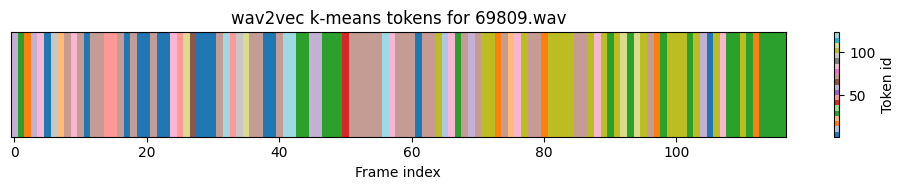


File: 71889.wav
Num frames (tokens): 65
Top token IDs (id: count):
  31: 26
  82: 10
  43: 10
  41: 8
  3: 5
  71: 2
  52: 2
  124: 1
  11: 1


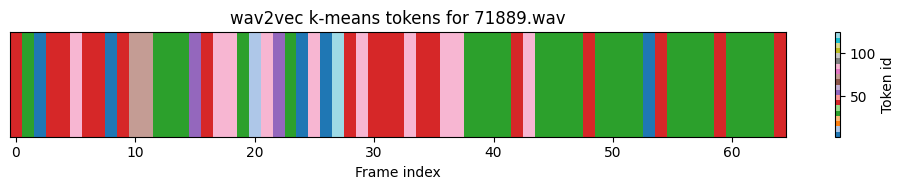


File: 46690.wav
Num frames (tokens): 93
Top token IDs (id: count):
  89: 26
  76: 26
  105: 11
  126: 8
  66: 6
  4: 5
  123: 3
  27: 3
  26: 2
  81: 1


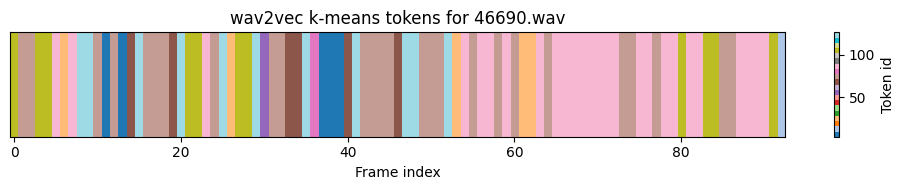

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Pick a few example files to inspect
sample_files = ann_small["File Name"].iloc[:3]

for fn in sample_files:
    stem = Path(fn).stem
    token_path = KMEANS_DIR / f"w2v_kmeans_{stem}.npy"
    if not token_path.exists():
        print(f"Skipping {fn}: tokens not found at {token_path}")
        continue

    tokens = np.load(token_path)

    print("\n" + "=" * 80)
    print(f"File: {fn}")
    print(f"Num frames (tokens): {len(tokens)}")

    # Show the most frequent token IDs
    uniq, counts = np.unique(tokens, return_counts=True)
    order = np.argsort(counts)[::-1]
    top_k = 10
    print("Top token IDs (id: count):")
    for i in order[:top_k]:
        print(f"  {int(uniq[i])}: {int(counts[i])}")

    # Visualize the token sequence over time as a 1D image
    plt.figure(figsize=(10, 2))
    plt.imshow(tokens[None, :], aspect="auto", interpolation="nearest", cmap="tab20")
    plt.yticks([])
    plt.xlabel("Frame index")
    plt.title(f"wav2vec k-means tokens for {fn}")
    plt.colorbar(label="Token id")
    plt.tight_layout()
    plt.show()

### Visualize wav2vec tokens aligned with the original waveform

The cell below, for a few example files:
- Loads the original waveform (resampled to 16 kHz for wav2vec2)
- Loads the saved k-means token sequence
- Plots waveform amplitude over time and the token IDs over time on a shared x-axis
- (Optionally) plays back the audio so you can listen while looking at the tokens.


File: 69809.wav
Waveform samples: 37803 at 16000 Hz (duration ~2.36s)
Num tokens: 117; token rate ~49.5 Hz


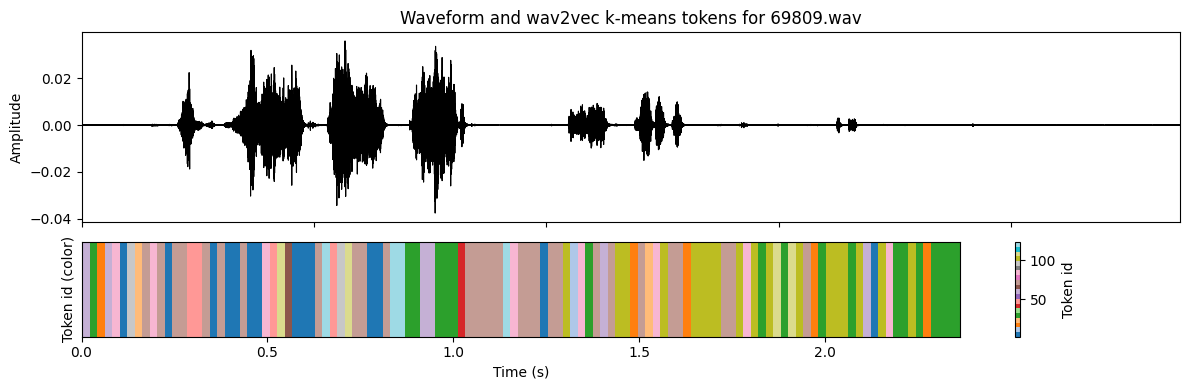


File: 71889.wav
Waveform samples: 21026 at 16000 Hz (duration ~1.31s)
Num tokens: 65; token rate ~49.5 Hz


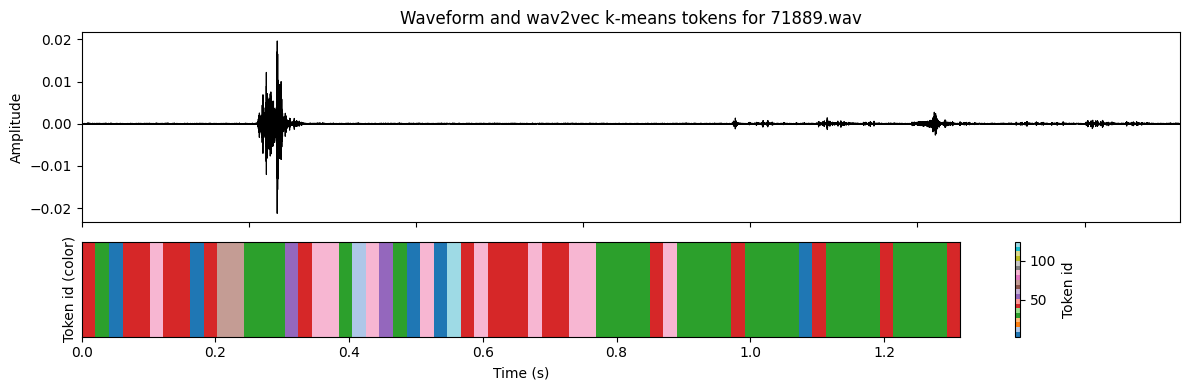


File: 46690.wav
Waveform samples: 29939 at 16000 Hz (duration ~1.87s)
Num tokens: 93; token rate ~49.7 Hz


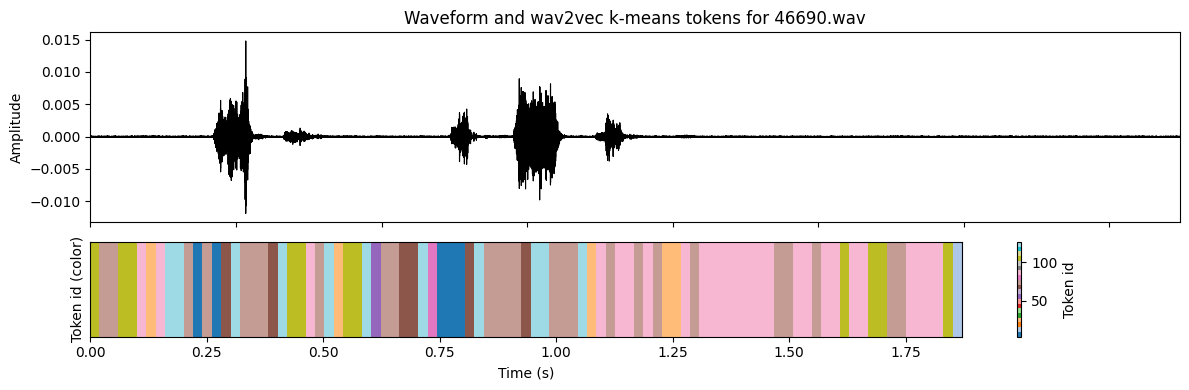

In [ ]:
import IPython.display as ipd

# visualize tokens vs waveform for a single file

def plot_waveform_and_tokens(fn: str, max_duration: float | None = None) -> None:
    """Plot waveform (16 kHz) and wav2vec k-means tokens over time for one file."""
    wav_path = AUDIO_DIR / fn
    stem = Path(fn).stem
    token_path = KMEANS_DIR / f"w2v_kmeans_{stem}.npy"

    if not wav_path.exists():
        print(f"Missing audio: {wav_path}")
        return
    if not token_path.exists():
        print(f"Missing tokens: {token_path}")
        return

    # load audio in the same way we fed it to wav2vec2
    wav_16k = load_audio_for_w2v(wav_path, target_sr=16_000)
    sr = 16_000

    if max_duration is not None:
        max_samples = int(max_duration * sr)
        wav_16k = wav_16k[:max_samples]

    tokens = np.load(token_path)

    duration = len(wav_16k) / sr
    t_wave = np.linspace(0.0, duration, num=len(wav_16k))
    # spread token centers uniformly over the duration
    t_tok = np.linspace(0.0, duration, num=len(tokens))

    print(f"\nFile: {fn}")
    print(f"Waveform samples: {len(wav_16k)} at {sr} Hz (duration ~{duration:.2f}s)")
    print(f"Num tokens: {len(tokens)}; token rate ~{len(tokens)/duration:.1f} Hz")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 4), sharex=True,
                                   gridspec_kw={"height_ratios": [2, 1]})

    # waveform
    ax1.plot(t_wave, wav_16k, color="black", linewidth=0.8)
    ax1.set_ylabel("Amplitude")
    ax1.set_title(f"Waveform and wav2vec k-means tokens for {fn}")

    # tokens as a 1D image
    im = ax2.imshow(
        tokens[None, :],
        aspect="auto",
        interpolation="nearest",
        cmap="tab20",
        extent=[0.0, duration, 0.0, 1.0],
    )
    ax2.set_yticks([])
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Token id (color)")
    fig.colorbar(im, ax=ax2, label="Token id")

    plt.tight_layout()
    plt.show()


# visualize a few example files
example_files = ann_small["File Name"].iloc[:3]
for fn in example_files:
    plot_waveform_and_tokens(fn, max_duration=5.0)  # cap at 5s for readability


### Discretize frame-level tokens into chunk-level tokens (run-length compression)

The code below:
- Takes the per-frame wav2vec k-means tokens for a file.
- Collapses consecutive identical tokens into **chunks** (run-length encoding).
- Plots the 16 kHz waveform and these chunk-level tokens over time so that
  the number of color blocks is closer to the number of perceptual chunks in the audio.


File: 69809.wav
Waveform samples: 37803 at 16000 Hz (duration ~2.36s)
Frame-level tokens: 117
Chunk-level tokens after compression: 90


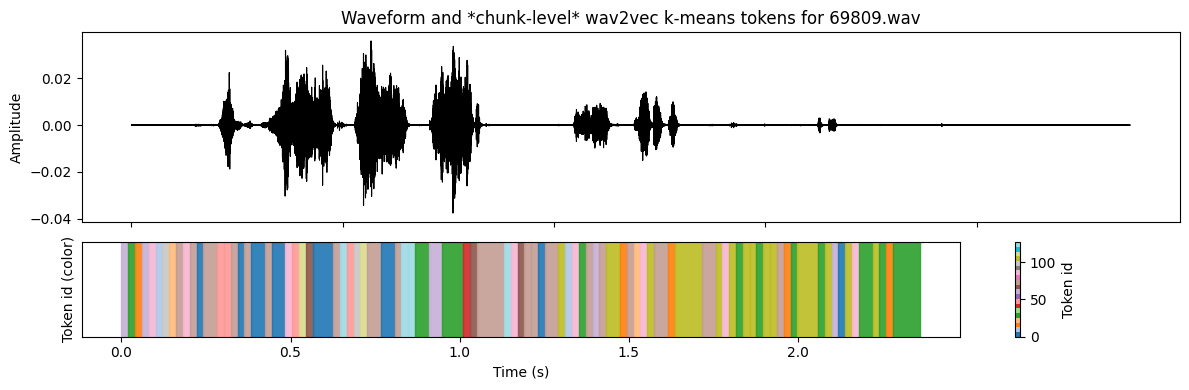


File: 71889.wav
Waveform samples: 21026 at 16000 Hz (duration ~1.31s)
Frame-level tokens: 65
Chunk-level tokens after compression: 44


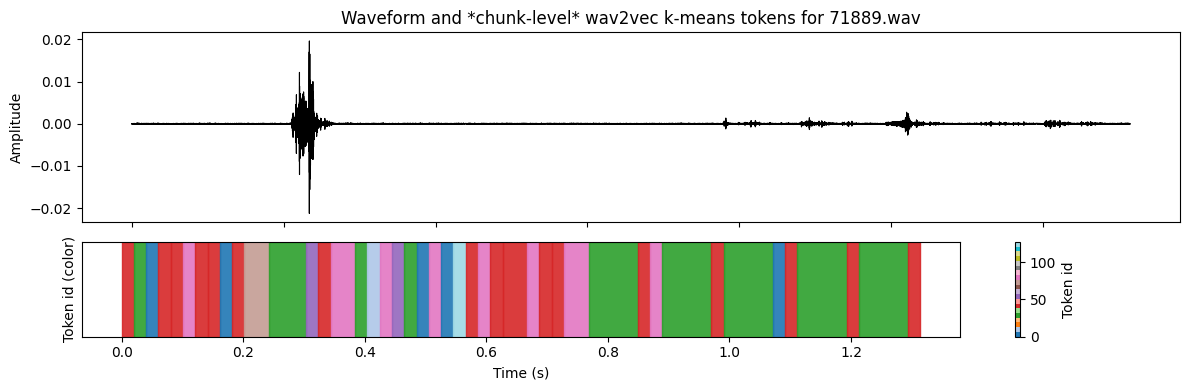


File: 46690.wav
Waveform samples: 29939 at 16000 Hz (duration ~1.87s)
Frame-level tokens: 93
Chunk-level tokens after compression: 59


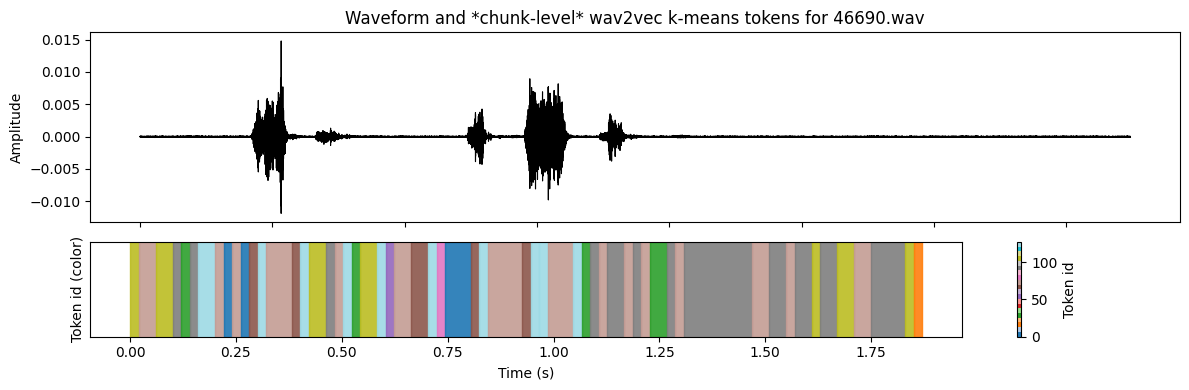

In [ ]:
from matplotlib import colors


def compress_tokens(tokens: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Run-length encode a 1D token sequence.

    Returns
    -------
    chunk_tokens : np.ndarray[int]
        Token id for each chunk.
    starts : np.ndarray[int]
        Start frame index (inclusive) for each chunk.
    ends : np.ndarray[int]
        End frame index (exclusive) for each chunk.
    """
    if len(tokens) == 0:
        return np.array([], dtype=int), np.array([], dtype=int), np.array([], dtype=int)

    changes = np.where(np.diff(tokens) != 0)[0] + 1
    boundaries = np.concatenate(([0], changes, [len(tokens)]))

    chunk_tokens = []
    starts = []
    ends = []
    for i in range(len(boundaries) - 1):
        s, e = int(boundaries[i]), int(boundaries[i + 1])
        chunk_tokens.append(int(tokens[s]))
        starts.append(s)
        ends.append(e)

    return np.asarray(chunk_tokens, dtype=int), np.asarray(starts, dtype=int), np.asarray(ends, dtype=int)


def plot_waveform_and_chunks(fn: str, max_duration: float | None = None) -> None:
    """Plot waveform and *chunk-level* tokens (run-length compressed) for one file."""
    wav_path = AUDIO_DIR / fn
    stem = Path(fn).stem
    token_path = TOKENS_DIR / f"w2v_kmeans_{stem}.npy"

    if not wav_path.exists():
        print(f"Missing audio: {wav_path}")
        return
    if not token_path.exists():
        print(f"Missing tokens: {token_path}")
        return

    # Load audio at 16 kHz (same as wav2vec2)
    wav_16k = load_audio_for_w2v(wav_path, target_sr=16_000)
    sr = 16_000
    if max_duration is not None:
        max_samples = int(max_duration * sr)
        wav_16k = wav_16k[:max_samples]

    tokens = np.load(token_path)
    chunk_tokens, starts, ends = compress_tokens(tokens)

    duration = len(wav_16k) / sr
    t_wave = np.linspace(0.0, duration, num=len(wav_16k))

    # Map frame indices to time
    t_starts = starts / len(tokens) * duration
    t_ends = ends / len(tokens) * duration

    print("\n" + "=" * 80)
    print(f"File: {fn}")
    print(f"Waveform samples: {len(wav_16k)} at {sr} Hz (duration ~{duration:.2f}s)")
    print(f"Frame-level tokens: {len(tokens)}")
    print(f"Chunk-level tokens after compression: {len(chunk_tokens)}")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 4), sharex=True,
                                   gridspec_kw={"height_ratios": [2, 1]})

    # Waveform
    ax1.plot(t_wave, wav_16k, color="black", linewidth=0.8)
    ax1.set_ylabel("Amplitude")
    ax1.set_title(f"Waveform and *chunk-level* wav2vec k-means tokens for {fn}")

    # Chunk-level tokens as colored spans
    cmap = plt.get_cmap("tab20")
    norm = colors.Normalize(vmin=0, vmax=N_CLUSTERS - 1)

    for t0, t1, tok in zip(t_starts, t_ends, chunk_tokens):
        ax2.axvspan(t0, t1, color=cmap(norm(tok)), alpha=0.9)

    ax2.set_yticks([])
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Token id (color)")
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax2, label="Token id")

    plt.tight_layout()
    plt.show()


# visualize chunk-level tokens for a few example files
example_files = ann_small["File Name"].iloc[:3]
for fn in example_files:
    plot_waveform_and_chunks(fn, max_duration=5.0)


### 4. Energy-based / spectral segmentation (VAD-style chunks)

The cells below implement a simple energy-based segmentation:

1. Compute short-time RMS energy over the waveform.
2. Use a dynamic threshold: `median(energy) + k * std(energy)`.
3. Mark regions where energy is above threshold for >10 ms.
4. Merge neighboring regions with gaps < 20 ms.
5. Treat each merged region as an acoustic "chunk" and visualize them over the waveform and energy.


File: 69809.wav
Sample rate: 250000 Hz | duration ~2.36s
Detected 4 energy-based chunks:
  chunk 0: 0.358s - 0.453s (dur ~0.094s)
  chunk 1: 0.537s - 0.644s (dur ~0.108s)
  chunk 2: 0.725s - 0.800s (dur ~0.075s)
  chunk 3: 1.206s - 1.223s (dur ~0.016s)


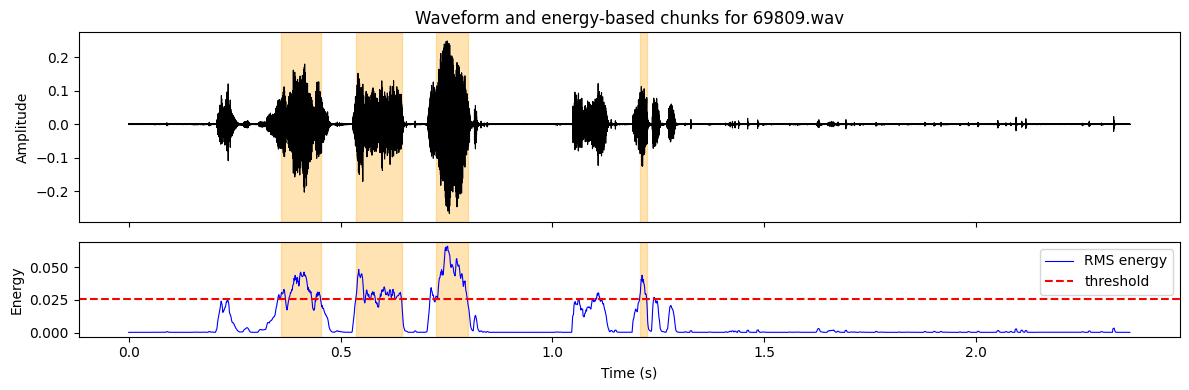


File: 71889.wav
Sample rate: 250000 Hz | duration ~1.31s
Detected 1 energy-based chunks:
  chunk 0: 0.214s - 0.244s (dur ~0.030s)


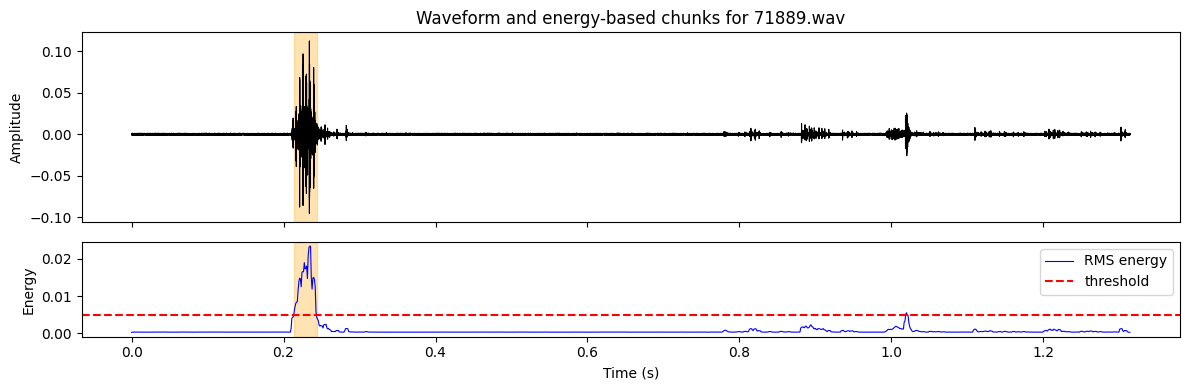


File: 46690.wav
Sample rate: 250000 Hz | duration ~1.87s
Detected 3 energy-based chunks:
  chunk 0: 0.221s - 0.266s (dur ~0.045s)
  chunk 1: 0.631s - 0.644s (dur ~0.013s)
  chunk 2: 0.731s - 0.800s (dur ~0.069s)


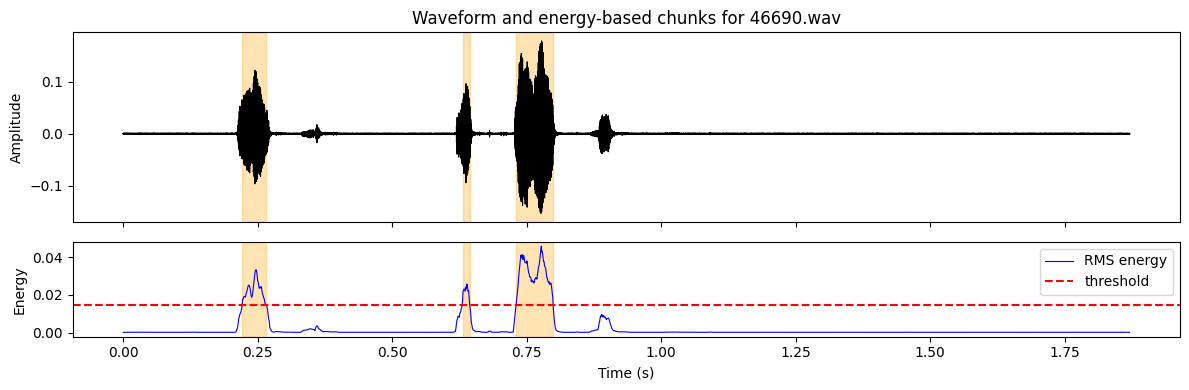

In [12]:
from typing import List, Tuple


def energy_segments(
    y: np.ndarray,
    sr: int,
    frame_length: int = 1024,
    hop_length: int = 256,
    min_chunk_ms: float = 10.0,
    merge_gap_ms: float = 20.0,
    thresh_scale: float = 2.0,
) -> Tuple[List[Tuple[float, float]], np.ndarray, np.ndarray, float]:
    """Compute energy-based chunks using a simple VAD-style heuristic.

    Returns
    -------
    segments : list of (t_start, t_end) in seconds
    times : np.ndarray
        Frame center times (seconds) for the RMS energy.
    energy : np.ndarray
        RMS energy per frame.
    threshold : float
        Energy threshold used.
    """
    # Short-time RMS energy
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    times = librosa.frames_to_time(np.arange(len(rms)), sr=sr, hop_length=hop_length)

    # Dynamic threshold
    thr = np.median(rms) + thresh_scale * np.std(rms)

    active = rms > thr
    segments: List[Tuple[float, float]] = []

    start_idx = None
    for i, a in enumerate(active):
        if a and start_idx is None:
            start_idx = i
        elif not a and start_idx is not None:
            end_idx = i
            segments.append((times[start_idx], times[end_idx]))
            start_idx = None

    if start_idx is not None:
        segments.append((times[start_idx], times[len(active) - 1]))

    # Filter by minimum duration
    min_dur = min_chunk_ms / 1000.0
    segments = [(s, e) for (s, e) in segments if (e - s) >= min_dur]

    # Merge small gaps
    merge_gap = merge_gap_ms / 1000.0
    if not segments:
        return [], times, rms, thr

    merged: List[Tuple[float, float]] = [segments[0]]
    for s, e in segments[1:]:
        last_s, last_e = merged[-1]
        if s - last_e <= merge_gap:
            merged[-1] = (last_s, e)
        else:
            merged.append((s, e))

    return merged, times, rms, thr


def plot_energy_chunks(fn: str, max_duration: float | None = None) -> None:
    """Visualize VAD-style energy-based chunks for a given file."""
    wav_path = AUDIO_DIR / fn
    if not wav_path.exists():
        print(f"Missing audio: {wav_path}")
        return

    # Load at native sample rate for energy-based VAD
    y, sr = librosa.load(wav_path, sr=None)
    if max_duration is not None:
        max_samples = int(max_duration * sr)
        y = y[:max_samples]

    duration = len(y) / sr
    t_wave = np.linspace(0.0, duration, num=len(y))

    segments, times, rms, thr = energy_segments(y, int(sr))

    print("\n" + "=" * 80)
    print(f"File: {fn}")
    print(f"Sample rate: {sr} Hz | duration ~{duration:.2f}s")
    print(f"Detected {len(segments)} energy-based chunks:")
    for i, (s, e) in enumerate(segments):
        print(f"  chunk {i}: {s:.3f}s - {e:.3f}s (dur ~{e - s:.3f}s)")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 4), sharex=True,
                                   gridspec_kw={"height_ratios": [2, 1]})

    # Waveform with chunks overlaid
    ax1.plot(t_wave, y, color="black", linewidth=0.8)
    for s, e in segments:
        ax1.axvspan(s, e, color="orange", alpha=0.3)
    ax1.set_ylabel("Amplitude")
    ax1.set_title(f"Waveform and energy-based chunks for {fn}")

    # Energy trace and threshold
    ax2.plot(times, rms, color="blue", linewidth=0.8, label="RMS energy")
    ax2.axhline(thr, color="red", linestyle="--", label="threshold")
    for s, e in segments:
        ax2.axvspan(s, e, color="orange", alpha=0.3)

    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Energy")
    ax2.legend(loc="upper right")

    plt.tight_layout()
    plt.show()


# Visualize energy-based chunks for a few example files
example_files = ann_small["File Name"].iloc[:3]
for fn in example_files:
    plot_energy_chunks(fn, max_duration=5.0)


In [16]:
from pathlib import Path

# directory to store per-file energy-based segments
ENERGY_SEG_DIR = DERIVED_DIR / "energy_segments"
ENERGY_SEG_DIR.mkdir(exist_ok=True, parents=True)

files = ann_small["File Name"]
n_files = len(files)
print(f"Computing energy-based segments for {n_files} files into {ENERGY_SEG_DIR} ...")

for idx, fn in enumerate(files, start=1):
    wav_path = AUDIO_DIR / fn
    if not wav_path.exists():
        print(f"[warn] missing audio: {wav_path}")
        continue

    # load at native sample rate
    y, sr = librosa.load(wav_path, sr=None)

    # use the previously defined energy_segments function
    segments, times, rms, thr = energy_segments(y, int(sr))

    # segments is a list of (start_sec, end_sec); save as (N, 2) float32 array
    if segments:
        seg_arr = np.asarray(segments, dtype=np.float32)
    else:
        seg_arr = np.empty((0, 2), dtype=np.float32)

    out_path = ENERGY_SEG_DIR / f"{Path(fn).stem}_segments.npy"
    np.save(out_path, seg_arr)

    if idx % 100 == 0 or idx == n_files:
        print(f"[energy] processed {idx}/{n_files} files")

len(list(ENERGY_SEG_DIR.glob("*.npy")))

Computing energy-based segments for 10000 files into /Users/mahikacalyanakoti/Downloads/College/Year4/Year4Sem1/ESE5460/bat-llm/starter_code/derived/energy_segments ...
[energy] processed 100/10000 files
[energy] processed 200/10000 files
[energy] processed 300/10000 files
[energy] processed 400/10000 files
[energy] processed 500/10000 files
[energy] processed 600/10000 files
[energy] processed 700/10000 files
[energy] processed 800/10000 files
[energy] processed 900/10000 files
[energy] processed 1000/10000 files
[energy] processed 1100/10000 files
[energy] processed 1200/10000 files
[energy] processed 1300/10000 files
[energy] processed 1400/10000 files
[energy] processed 1500/10000 files
[energy] processed 1600/10000 files
[energy] processed 1700/10000 files
[energy] processed 1800/10000 files
[energy] processed 1900/10000 files
[energy] processed 2000/10000 files
[energy] processed 2100/10000 files
[energy] processed 2200/10000 files
[energy] processed 2300/10000 files
[energy] pro

10000